This notebook contains code to reproduce the multi-fidelity neural network function approximation results from Meng and Karniadakis 2019. 

In [1]:
''' Magics '''
%matplotlib notebook

''' Relevant imports '''
import torch
import math
from math import cos, sin, atan
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import matplotlib 
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits import mplot3d

In [2]:
from utils.visualize_network import visualize_network

In [223]:
class Network(): 
    def __init__(
        self, 
        vertical_distance_between_layers, 
        horizontal_distance_between_neurons, 
        neuron_radius, 
        number_of_neurons_in_widest_layer,
        neuron_colors=("black", "green"),
        network_colors=("blue", "red"),
        width_scale=1, 
    ):
        # Layers is a dictionary which keeps track of the number of 
        # layers and the number of neurons in each layer.
        self.layers = {}                                                               
        self.vertical_distance_between_layers = vertical_distance_between_layers
        self.horizontal_distance_between_neurons = horizontal_distance_between_neurons
        self.neuron_radius = neuron_radius
        self.number_of_neurons_in_widest_layer = number_of_neurons_in_widest_layer
        self.neuron_colors = neuron_colors
        self.network_colors = network_colors    
        self.width_scale=width_scale
        self.previous_layer = None
        
    ''' Function add_layer adds a new layer to the network, with a specified name and 
        number of neurons, and, optionally, color to draw the neurons in. Returns the
        newly created layer. '''
    def add_layer(self, layer_name, number_of_neurons, neuron_colors=None): 
        new_layer = Layer(
            number_of_neurons, 
            layer_name,
            self.previous_layer,
            neuron_colors,
            network
        )
        self.layers[layer_name] = new_layer
        self.previous_layer = new_layer 

    ''' Function __line_between_two_neurons draws the connection between two neurons 
        using the specified edge color. '''
    def __line_between_two_neurons(self, neuron1, neuron2, linewidth, color_id):
        angle = atan((neuron2.x - neuron1.x) / float(neuron2.y - neuron1.y))
        x_adjustment = self.neuron_radius*.2 * sin(angle)
        y_adjustment = self.neuron_radius*.2 * cos(angle)
        line_x_data = (neuron1.x - x_adjustment, neuron2.x + x_adjustment)
        line_y_data = (neuron1.y - y_adjustment, neuron2.y + y_adjustment)
        line = plt.Line2D(
            line_x_data, 
            line_y_data, 
            linewidth=self.width_scale*linewidth, 
            color=self.network_colors[color_id],
            zorder=5
        )
        plt.gca().add_line(line)

    ''' Function connect_layers connects two layers using the specified edge weights 
        (to control thickness) and edge colors. '''
    def connect_layers(self, layer1_name, layer2_name, weights_matrix, color_ids_matrix):
        if layer1_name and layer2_name in self.layers: 
            layer1 = self.layers[layer1_name]
            layer2 = self.layers[layer2_name]
        for (neuron2_index, neuron2) in enumerate(layer2.neurons): 
            for (neuron1_index, neuron1) in enumerate(layer1.neurons):
                self.__line_between_two_neurons(
                    neuron1, 
                    neuron2, 
                    weights_matrix[neuron2_index, neuron1_index],
                    int(color_ids_matrix[neuron2_index, neuron1_index]),
                )

    ''' Function draw_neurons draws all neurons in the network.'''
    def draw_neurons(self): 
        for (layer_key, layer) in self.layers.items(): 
            for neuron in layer.neurons: 
                neuron.draw()
        plt.axis('scaled')
        plt.show()
                
class Layer(): 
    def __init__(
        self, 
        number_of_neurons,
        name,
        previous_layer,
        neuron_colors,
        network
    ):
        self.name = name
        self.previous_layer = previous_layer
        self.y = self.__calculate_layer_y_position()
        self.neurons = self.__intialise_neurons(number_of_neurons, neuron_colors)
        self.network = network
        
    '''Initializes neurons in the layer.'''
    def __intialise_neurons(self, number_of_neurons, neuron_colors):
        neurons = []
        x = self.__calculate_left_margin_so_layer_is_centered(number_of_neurons)
        for iteration in range(number_of_neurons):
            if neuron_colors: 
                neuron = Neuron(x, self.y, color=colors[iteration])
            else: 
                neuron = Neuron(x, self.y)
            neurons.append(neuron)
            x += self.network.horizontal_distance_between_neurons
        return neurons

    '''Calculates y position for the layer's neurons'''
    def __calculate_layer_y_position(self):
        if self.previous_layer:
            return self.previous_layer.y + self.network.vertical_distance_between_layers
        else:
            return 0
        
    '''Calculuates left margin to center the layers.'''
    def __calculate_left_margin_so_layer_is_centered(self, number_of_neurons):
        return self.network.horizontal_distance_between_neurons * (number_of_neurons_in_widest_layer - number_of_neurons) / 2
        
class Neuron(): 
    '''A Neuron instance draws itself in the correct position.'''
    def __init__(self, x, y, color="black"): 
        self.x = x
        self.y = y
        self.color = color
        
    def draw(self): 
        circle = plt.Circle((self.x, self.y), radius=neuron_radius, fill=True, color=self.color, zorder=10)
        plt.gca().add_patch(circle)

<IPython.core.display.Javascript object>


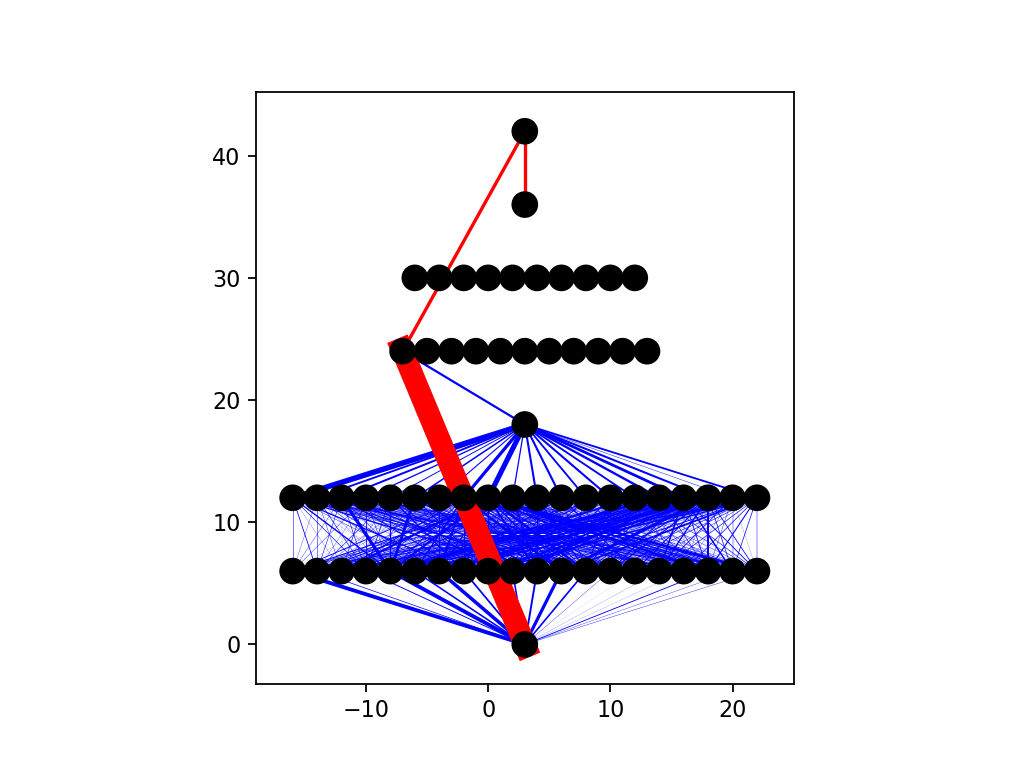

In [231]:
def visualize_network(
    nn_mfl, 
    vertical_distance_between_layers = 6,
    horizontal_distance_between_neurons = 2,
    neuron_radius = 1,
    number_of_neurons_in_widest_layer = 4,
    width_scale=.5,
    input_dim=1, 
    output_dim=1,
):
    # Initialize network.
    network = Network( 
        vertical_distance_between_layers, 
        horizontal_distance_between_neurons, 
        neuron_radius, 
        number_of_neurons_in_widest_layer,
        width_scale=width_scale,
    )

    # Add all layers in nn_l.
    weights_to_prev = None
    prev_layer_name = None
    iters = 0 
    for name, param in nn_mfl.named_parameters(): 
        # Skip the biases. 
        if "weight" not in name: 
            continue 
       # When we get to nn_h1, add the output layer and break.
        if "nn_l" not in name: 
            name = 'y_l'
            network.add_layer(name, weights_to_prev.shape[0])
            network.connect_layers(
                prev_layer_name, 
                name,
                weights_to_prev,
                np.zeros(weights_to_prev.shape)
            )
            prev_layer_name = name
            break
        # Don't add any weights until we have both layers in the network. 
        if prev_layer_name: 
            # Add the layer by name and size.
            network.add_layer(name, param.shape[1])
            # Add edges.
            network.connect_layers(
                prev_layer_name, 
                name,
                weights_to_prev,
                np.zeros(weights_to_prev.shape)
            )
            # Updated previous weights and previous layer.
            weights_to_prev = param.data.numpy() 
            prev_layer_name = name
        else: 
            # Add the layer by name and size.
            network.add_layer(name, param.shape[1])
            # Update weights and previous layer.
            weights_to_prev = param.data.numpy()
            prev_layer_name = name
            
    # Add all layers in nn_h1 and nn_h2
    for name, param in nn_mfl.named_parameters(): 
        # Skip the biases. 
        if "weight" not in name: 
            continue 
        if "nn_h1" in name and "0.weight" in name: 
            nn_h1_layer0_num_neurons = param.shape[0]
            nn_h1_layer0_weights = param.data.numpy()[:, -output_dim].reshape(
                (nn_h1_layer0_num_neurons, output_dim)
            )
            nn_h1_x_weights = param.data.numpy()[:, 0:input_dim].reshape(
                (nn_h1_layer0_num_neurons, input_dim)
            )
        elif "nn_h2" in name and "0.weight" in name: 
            nn_h2_layer0_num_neurons = param.shape[0]
            nn_h2_layer0_weights = param.data.numpy()[:, -output_dim].reshape(
                (nn_h2_layer0_num_neurons, output_dim)
            )
            nn_h2_x_weights = param.data.numpy()[:, 0:input_dim].reshape(
                (nn_h2_layer0_num_neurons, input_dim)
            )
            # Optionally nn_h2 may take additional inputs (such as a time-delayed 
            # low-fidelity prediction), so we want to save these
            nn_h2_extra_weights = param.data.numpy()[:, input_dim:-output_dim].reshape(
                (nn_h2_layer0_num_neurons, param.shape[1]-input_dim-output_dim)
            )
            # Add the layer with name, size, and weights 
            nn_h_layer0_weights = np.concatenate((nn_h1_layer0_weights, nn_h2_layer0_weights), axis=0)
            network.add_layer('nn_h_layer0', nn_h1_layer0_num_neurons + nn_h2_layer0_num_neurons)
            network.connect_layers(
                'y_l', 
                'nn_h_layer0',
                nn_h_layer0_weights,
                np.zeros(nn_h_layer0_weights.shape)
            )
            # Update previous layer name for constructing the rest of nn_h2
            prev_layer_name = "nn_h_layer0"
        # After this point, only nn_h2 layers should remain to be added. 
        elif "nn_h2" in name and "1.weight" in name: 
            network.add_layer(name, param.shape[0])
            weights = param.data.numpy()
            weights = np.concatenate((np.zeros((weights.shape[0], output_dim)), weights), axis=1)
            network.connect_layers(
                prev_layer_name, 
                name, 
                weights,
                np.zeros(weights.shape)
            )
            prev_layer_name = name
        elif "nn_h2" in name: 
            network.add_layer(name, param.shape[0])
            network.connect_layers(
                prev_layer_name, 
                name, 
                param.data.numpy(),
                np.zeros(param.data.numpy().shape)
            )
            prev_layer_name = name
    # Draw connections between the first layer and the first high fidelity layer
    first_layer_nn_h_weights = np.concatenate((nn_h1_x_weights, nn_h2_x_weights), axis=0)
    network.connect_layers(
        "nn_l.linear_layers.0.weight", 
        "nn_h_layer0", 
        first_layer_nn_h_weights,
        np.ones(first_layer_nn_h_weights.shape)
    )
    # Draw connections between F_l, F_nl and the final output
    network.add_layer('y_h', output_dim)
    weights = np.zeros((output_dim, len(network.layers['nn_h_layer0'].neurons)))
    weights[0:output_dim, 0:output_dim] = 1
    network.connect_layers(
        'nn_h_layer0', 
        'y_h',
        weights*3,
        np.ones(weights.shape)
    )
    weights = np.ones((output_dim, output_dim))
    network.connect_layers(
        prev_layer_name, 
        'y_h',
        weights*3,
        np.ones(weights.shape)
    )
    # Draw the neurons
    network.draw_neurons()

visualize_network(nn_mfl)

In [153]:
for name, param in nn_mfl.named_parameters(): 
    print(name)
    print(param.shape)

nn_l.linear_layers.0.weight
torch.Size([20, 1])
nn_l.linear_layers.0.bias
torch.Size([20])
nn_l.linear_layers.1.weight
torch.Size([20, 20])
nn_l.linear_layers.1.bias
torch.Size([20])
nn_l.linear_layers.2.weight
torch.Size([1, 20])
nn_l.linear_layers.2.bias
torch.Size([1])
nn_h1.linear_layers.0.weight
torch.Size([1, 2])
nn_h1.linear_layers.0.bias
torch.Size([1])
nn_h2.linear_layers.0.weight
torch.Size([10, 2])
nn_h2.linear_layers.0.bias
torch.Size([10])
nn_h2.linear_layers.1.weight
torch.Size([10, 10])
nn_h2.linear_layers.1.bias
torch.Size([10])
nn_h2.linear_layers.2.weight
torch.Size([1, 10])
nn_h2.linear_layers.2.bias
torch.Size([1])


In [667]:
%matplotlib notebook
class Neuron():
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def draw(self):
        circle = plt.Circle((self.x, self.y), radius=neuron_radius, fill=False)
        plt.gca().add_patch(circle)


class Layer():
    def __init__(
        self, 
        network, 
        number_of_neurons, 
        weights, 
        first_layer_weights, 
        first_hf_layer_weights,
        is_first_layer, 
        is_first_hf_layer, 
        is_last_layer,
    ):
        self.previous_layer = self.__get_previous_layer(network)
        self.y = self.__calculate_layer_y_position()
        self.neurons = self.__intialise_neurons(number_of_neurons)
        # Weight matrix to next layer 
        self.weights = weights
        # Weight matrix to NN_l
        self.first_layer_weights=first_layer_weights
        # Weight matrix to NN_H1
        self.first_hf_layer_weights=first_hf_layer_weights
        # Booleans to keep track of current status 
        self.is_first_layer = is_first_layer
        self.is_first_hf_layer = is_first_hf_layer
        self.is_last_layer = is_last_layer

    def __intialise_neurons(self, number_of_neurons):
        neurons = []
        x = self.__calculate_left_margin_so_layer_is_centered(number_of_neurons)
        for iteration in range(number_of_neurons):
            neuron = Neuron(x, self.y)
            neurons.append(neuron)
            x += horizontal_distance_between_neurons
        return neurons

    def __calculate_left_margin_so_layer_is_centered(self, number_of_neurons):
        return horizontal_distance_between_neurons * (number_of_neurons_in_widest_layer - number_of_neurons) / 2

    def __calculate_layer_y_position(self):
        if self.previous_layer:
            return self.previous_layer.y + vertical_distance_between_layers
        else:
            return 0

    def __get_previous_layer(self, network):
        if len(network.layers) > 0:
            return network.layers[-1]
        else:
            return None

    def __line_between_two_neurons(self, neuron1, neuron2, linewidth, color):
        angle = atan((neuron2.x - neuron1.x) / float(neuron2.y - neuron1.y))
        x_adjustment = neuron_radius * sin(angle)
        y_adjustment = neuron_radius * cos(angle)
        line_x_data = (neuron1.x - x_adjustment, neuron2.x + x_adjustment)
        line_y_data = (neuron1.y - y_adjustment, neuron2.y + y_adjustment)
        line = plt.Line2D(line_x_data, line_y_data, linewidth=linewidth, color=color)
        plt.gca().add_line(line)

    def draw(self, first_layer = None, first_hf_layer = None, color="blue", out_dim=None):
        for this_layer_neuron_index in range(len(self.neurons)):
            neuron = self.neurons[this_layer_neuron_index]
            neuron.draw()
            if self.previous_layer:
                for previous_layer_neuron_index in range(len(self.previous_layer.neurons)):
                    previous_layer_neuron = self.previous_layer.neurons[previous_layer_neuron_index]
                    weight = self.previous_layer.weights[this_layer_neuron_index, previous_layer_neuron_index]
                    self.__line_between_two_neurons(neuron, previous_layer_neuron, weight, color=color)
            if first_layer: 
                for first_layer_neuron_index in range(len(first_layer.neurons)):
                    first_layer_neuron = first_layer.neurons[first_layer_neuron_index]
                    weight = self.first_layer_weights[this_layer_neuron_index, first_layer_neuron_index]
                    self.__line_between_two_neurons(neuron, first_layer_neuron, weight, color=color)
            if first_hf_layer: 
                for first_hf_layer_neuron_index in range(min(len(first_hf_layer.neurons), out_dim)):
                    first_hf_layer_neuron = first_hf_layer.neurons[first_hf_layer_neuron_index]
                    weight = self.first_hf_layer_weights[this_layer_neuron_index, first_hf_layer_neuron_index]
                    self.__line_between_two_neurons(neuron, first_hf_layer_neuron, weight, color=color)

class NeuralNetwork():
    def __init__(self, colors=("red", "blue"), dim_out=1):
        self.layers = []
        self.first_layer = None
        self.first_hf_layer = None
        self.colors = colors
        self.dim_out = dim_out

    def add_layer(
        self, 
        number_of_neurons, 
        weights=None, 
        first_layer_weights=None, 
        first_hf_layer_weights=None,
        is_first_layer=False, 
        is_first_hf_layer=False,
        is_last_layer=False,
    ):
        layer = Layer(
            self, 
            number_of_neurons, 
            weights=weights, 
            first_layer_weights=first_layer_weights, 
            first_hf_layer_weights=first_hf_layer_weights,
            is_first_layer=is_first_layer, 
            is_first_hf_layer=is_first_hf_layer, 
            is_last_layer=is_last_layer,
        )
        if layer.is_first_layer: 
            self.first_layer = layer
        if layer.is_first_hf_layer:
            self.first_hf_layer = layer
        self.layers.append(layer)

    def draw(self):
        for layer in self.layers:
            if layer.is_first_hf_layer:
                layer.draw(self.first_layer, color=self.colors[0])
            if layer.is_last_layer: 
                layer.draw(self.first_hf_layer, color=self.colors[0], dim_out = self.dim_out)
            else: 
                layer.draw(color=self.colors[1])
        plt.axis('scaled')
        plt.show()

In [126]:
network.previous_layer

In [66]:
class MFNN(nn.Module):
    ''' Multi-fidelity neural network (Meng and Karniadakis 2019): 
        - nn_l: a neural network which generates predictions of the low-fidelity data
        - nn_h1: a neural network which computes linear correlation between the low- and high-fidelity data 
        - nn_h2: a neural network which computes nonlinear correlation between the low- and high-fidelity data '''
    
    def __init__(self, nn_l, nn_h1, nn_h2, dim_out=1, use_yl2=False, tau=None):
        super(MFNN, self).__init__()
        self.nn_l = nn_l 
        self.nn_h1 = nn_h1
        self.nn_h2 = nn_h2 
        self.use_yl2 = use_yl2
        self.tau=tau
        self.dim_out=dim_out

    def forward(self, x):
        # Compute low-fidelity prediction (y_l) via nn_l. 
        y_l = self.nn_l(x)
        if self.use_yl2 and self.tau: 
            y_l2 = self.nn_l(x-self.tau)
        # Compute linear and nonlinear correlations (F_l, F_nl) via nn_h1 and nn_h2. 
        if self.use_yl2 and self.tau: 
            F_l = self.nn_h1(torch.cat((x, y_l), 1))
            F_nl = self.nn_h2(torch.cat((x, y_l, y_l2), 1))
        else: 
            F_l = self.nn_h1(torch.cat((x, y_l), 1))
            F_nl = self.nn_h2(torch.cat((x, y_l), 1))
        # Compute multi-fidelity prediction (h_1) from F_l and F_nl.
        y_h = F_l + F_nl
        return torch.cat((y_l, y_h), 1)
    
    def draw(self, 
             number_of_neurons_in_widest_layer,
             vertical_distance_between_layers = 6, 
             horizontal_distance_between_neurons = 2, 
             neuron_radius = 0.5,
            ): 
        network = NeuralNetwork()
        for (name, param) in self.named_parameters(): 
            network.add_layer(4, weights1)
        

In [67]:
class FNN(nn.Module):
    '''Fully-connected neural network implementation (FNN): 
       - layer_sizes: the sizes of the layers from input to output layer 
       - activation (optional; default False): whether or not to use activation functions in this FNN. '''
    
    def __init__(self, layer_sizes, activation=True):
        super(FNN, self).__init__()
        # Create a list of linear layer modules of the specified sizes.  
        self.linear_layers = nn.ModuleList()
        self.activation = activation 
        for i in range(1, len(layer_sizes)): 
            self.linear_layers.append(nn.Linear(layer_sizes[i - 1], layer_sizes[i]))
            # Override default Lecun initialization to use Xavier's initialization method instead 
            nn.init.xavier_normal_(self.linear_layers[-1].weight)
    
    def forward(self, x):
        # Iterate through linear layers. 
        for linear_layer in self.linear_layers[:-1]: 
            # Apply activation to hidden layers if needed. 
            if self.activation: 
                x = torch.tanh(linear_layer(x))
            else: 
                x = linear_layer(x)
        # Don't use activation for last layer. 
        x = self.linear_layers[-1](x)
        return x

In [68]:
def train_MFNN(
    module, 
    num_epochs, 
    lr, 
    l2_lambda_h2, 
    train_data, 
    num_low, 
    num_high, 
    grad_low_fi=None, 
    l2_lambda_l=0, 
    verbose=False,
    p=2
): 
    ''' Runs end-to-end training for multi-fidelity neural network.
        - module: the torch module (i.e., neural network) to train 
        - num_epochs: number of epochs to train 
        - lr: learning rate
        - l2_lambda_h2: regularization rate for NNH2 
        - num_low: number of low-fidelity training data 
        - num_high: number of high-fidelity training data 
        - grad_low_fi (optional; default None): exact gradient of low-fidelity function, if available
        - l2_lambda_l (optional; default false): regularization rate for NNL
        - verbose (optiona; default False): whether to print information such as the current loss 
          periodically during training. '''
    
    # Set up optimizer. 
    optimizer = optim.LBFGS(module.parameters(), lr=lr)
    
    # Store inputs and targets, and gradients of low-fidelity function if available. 
    (inputs, targets) = (torch.narrow(train_data, 1, 0, 1), torch.narrow(train_data, 1, 1, 1))
    inputs.requires_grad = True 
    if grad_low_fi:
        GT_l = grad_low_fi(inputs[:][:num_low])
    losses = []

    # Define the loss criterion. 
    def loss_MFNN(preds, targets, inputs, print_grad=False):
        '''MSE loss calculation as specified in Meng and Karniadakis 2019'''
        
        # For low-fidelity train data, use low-fidelity prediction from nn_l. For high-fidelity train data,
        # use high-fidelity prediction from nn_h1 and nn_h2.
        Y_l = torch.narrow(torch.narrow(preds, 0, 0, num_low), 1, 0, 1)
        Y_h = torch.narrow(torch.narrow(preds, 0, num_low, num_high), 1, 1, 1)
        T_l, T_h = targets[:num_low], targets[num_low:]
        
        if grad_low_fi: 
            # Compute gradient penalty
            GY_l = torch.empty(size=(num_low, 1))
            for i in range(num_low): 
                x = inputs[:][i]
                y = module.nn_l(x)
                gyl = torch.autograd.grad(y, x, grad_outputs=torch.ones_like(y), retain_graph=True)[0]
                GY_l[i] = gyl
            if print_grad: 
                print(GY_l, flush=True)

        # Compute MSE terms from low_fidelity and high-fidelity contribution.
        if grad_low_fi: 
            MSE_l = torch.mean((Y_l - T_l)**2 + (GY_l[:][:num_low] - GT_l)**2)
        else: 
            MSE_l = torch.mean((Y_l - T_l)**2)
        MSE_h = torch.mean((Y_h - T_h)**2)  
        
        # Compute L2 regularization term from nn_l and nn_h2 parameters. Only penalize for size of weights 
        # (not biases). 
        l2_reg_l = torch.tensor(0., requires_grad=True)
        l2_reg_h2 = torch.tensor(0., requires_grad=True)
        for (name, param) in module.nn_l.named_parameters():
            if 'weight' in name: 
                l2_reg_l = l2_reg_l + torch.norm(param, p=p)**p
        for (name, param) in module.nn_h2.named_parameters(): 
            if 'weight' in name: 
                l2_reg_h2 = l2_reg_h2 + torch.norm(param, p=p)**p
        
        # Compute and return loss. 
        loss = MSE_l + MSE_h + l2_lambda_l*l2_reg_l + l2_lambda_h2*l2_reg_h2
        return loss
    
    # Define the closure to update weights in each epoch. 
    def closure(): 
        optimizer.zero_grad()
        preds = module(inputs)
        loss = loss_MFNN(preds, targets, inputs)
        loss.backward(retain_graph = True)
        return loss 
    
    # Loop for specified number of epochs. 
    for epoch in tqdm(range(num_epochs)): 
        optimizer.step(closure)                                 # step optimizer
        preds = module(inputs)                                  # compute new predictions
        losses.append(loss_MFNN(preds, targets, inputs).item()) # record loss
        if verbose and epoch % 100 == 0:
            loss_MFNN(preds, targets, inputs, print_grad=True).item()
    
    return losses
        

In [69]:
def setup_training(
    low_fi, 
    high_fi, 
    nn_l_layers, 
    nn_h1_layers, 
    nn_h2_layers, 
    low_pts, 
    high_pts, 
    nn_h_layers = None,
    use_yl2 = False, 
    tau = None,
): 
    '''Sets up model for training by formatting training data appropriately. 
       - low_fi: low-fidelity function handle 
       - high_fi: high-fidelity function handle 
       - nn_l_layers: list containing number of neurons per layer for NNL
       - nn_h2_layers: list containing number of neurons per layer for NNH2 
       - low_pts: low-fidelity training data input points 
       - high_pts: high-fidelity training data input points
       - nn_h_layers (default None): list containing number of neurons per layer for a FNN trained on high-fidelity
         data only (with no low-fidelity input for comparison. '''
    
    # Format train data.
    inputs = torch.transpose(torch.tensor([low_pts+high_pts]), 0, 1)
    num_low = len(low_pts)
    num_high = len(high_pts)
    low = low_fi(inputs[:][:num_low])
    high = high_fi(inputs[:][num_low:])
    train_data = torch.cat((inputs, torch.cat((low, high))), 1)

    # Initialize model.
    if nn_l_layers: 
        nn_l = FNN(nn_l_layers)
    if nn_h1_layers: 
        nn_h1 = FNN(nn_h1_layers, activation=False)         # no activations for NN_H1 
    if nn_h2_layers: 
        nn_h2 = FNN(nn_h2_layers)
    nn_mfl = MFNN(nn_l, nn_h1, nn_h2, use_yl2=use_yl2, tau=tau)
    
    # Initialize and return all information for training including the initialized model. Also include a 
    # newly initialized high-fidelity model, if specified in the inputs.
    if nn_h_layers: 
        nn_hfl = FNN(nn_h_layers)
        return (nn_mfl, nn_hfl, hfl, train_data, num_low, num_high)
    return (nn_mfl, train_data, num_low, num_high)


In [70]:
'''Generates plots for a given experiment. Provide: 
   - nn_mfl: the (trained) model 
   - train_data: the training data used  
   - num_low: number of low_fidelity data points used 
   - high_fi: a function to compute exact high-fidelity function value, given x
   - low_fi: a function to compute exact low-fidelity function value, given x
   - mesh_size (optional): how fine a mesh to use for plotting the exact and approximate functions. 
   - range_loss_plot (optional): lower bound of range for plotting loss vs epochs
'''
def generate_plots(
    nn_mfl, 
    train_data, 
    num_low, 
    high_fi, 
    low_fi, 
    losses, 
    mesh_size=1000, 
    range_loss_plot=None): 
    
    plt.subplots(figsize=(10,8))
    
    '''Plot the data (a) in paper. Plots training data as well as exact low- and high-fidelity functions.'''
    ax1 = plt.subplot(2, 2, 1)
    x_test = torch.linspace(0, 1, mesh_size).view(mesh_size, 1)
    y_l = low_fi(x_test)
    y_h = high_fi(x_test)
    ax1.plot(x_test, y_h, 'k', linewidth=2)
    ax1.plot(x_test, y_l, 'grey', linewidth=2)
    inputs = torch.narrow(train_data, 1, 0, 1)
    ax1.plot(inputs[:][:num_low], low_fi(inputs[:][:num_low]), 'bo', linewidth=5, markersize=8)
    ax1.plot(inputs[:][num_low:], high_fi(inputs[:][num_low:]), 'rx', linewidth=5, markersize=8, mew=2)
    ax1.set_xlabel("x")

    '''Plot the approximation (c) in paper. Plots exact and approximate low- and high-fidelity functions.'''
    ax2 = plt.subplot(2, 2, 2)
    preds = nn_mfl(x_test)
    x_test = torch.linspace(0, 1, mesh_size).view(mesh_size, 1)
    ax2.plot(x_test, y_h, 'k', linewidth=2)
    ax2.plot(x_test, y_l, 'grey', linewidth=2)
    ax2.plot(x_test, torch.narrow(preds, 1, 0, 1).detach().numpy(), 'b--', linewidth=2)
    ax2.plot(x_test, torch.narrow(preds, 1, 1, 1).detach().numpy(), 'r--', linewidth=2)
    ax2.set_xlabel("x")
#     ax2.set_xlim(0, 1)  
#     ax2.set_ylim(-1.5, 0) 
    
    '''Plot the correlations (d) in paper'''
    ax3 = plt.subplot(2, 2, 3, projection='3d')
    ax3.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax3.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax3.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax3.grid(False)
    ax3.plot(
        y_h.view(mesh_size).numpy(),
        y_l.view(mesh_size).numpy(), 
        x_test.view(mesh_size).numpy(),
        'k', 
        linewidth=2
    )
    ax3.plot(
        torch.narrow(preds, 1, 1, 1).detach().view(mesh_size).numpy(),
        torch.narrow(preds, 1, 0, 1).detach().view(mesh_size).numpy(), 
        x_test.view(mesh_size).numpy(),
        'r--',
        linewidth=2
    )
    ax3.plot(
        y_h.view(mesh_size).numpy(),
        y_l.view(mesh_size).numpy(), 
        np.zeros(mesh_size),
        'grey',
        linewidth=2
    )
    ax3.plot(
        torch.narrow(preds, 1, 1, 1).detach().view(mesh_size).numpy(),
        torch.narrow(preds, 1, 0, 1).detach().view(mesh_size).numpy(), 
        np.zeros(mesh_size),
        'b--',
        linewidth=2
    )
    ax3.set_xlabel("y_h")
    ax3.set_xlim(20, -20)  
    ax3.set_ylabel("y_l")
    ax3.set_ylim(-10, 10) 
    ax3.set_zlabel("x")
    ax3.set_zlim(0, 1)
    
    '''Plot the losses.'''
    ax4 = plt.subplot(2, 2, 4)
    if not range_loss_plot: 
        ax4.plot(range(len(losses)), losses)
    else: 
        ax4.plot(range(len(losses))[range_loss_plot:-1], losses[range_loss_plot:-1])
    ax4.set_xlabel("epoch")
    ax4.set_xlabel("loss")

In [71]:
''' EXAMPLE 1: Continuous function example. '''

def low_fi(x, A=.5, B=10, C=-5): 
    return A*(6*x-2)**2 * torch.sin(12*x-4) + B*(x-0.5) + C

def high_fi(x, A=.5, B=10, C=-5): 
    return (6*x-2)**2 * torch.sin(12*x-4)

def grad_low_fi(x, A=.5, B=10, C=-5): 
    return 6*torch.sin(12*x-4) + (72*x - 24)*torch.cos(12*x-4) + 10

# Setup training data.
(nn_mfl, train_data, num_low, num_high) = setup_training(
    low_fi, 
    high_fi, 
    [1, 20, 20, 1], 
    [2, 1], 
    [2, 10, 10, 1], 
    [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], 
    [0, 0.4, 0.6, 1]
)

# Define training parameters and run training loop.
num_epochs = 8000
lr = .001
l2_lambda_h2 = .1
losses = train_MFNN(
    nn_mfl, 
    num_epochs, 
    lr, 
    l2_lambda_h2, 
    train_data, 
    num_low, 
    num_high, 
    grad_low_fi=grad_low_fi
)

100%|██████████| 8000/8000 [03:11<00:00, 41.67it/s]


<IPython.core.display.Javascript object>


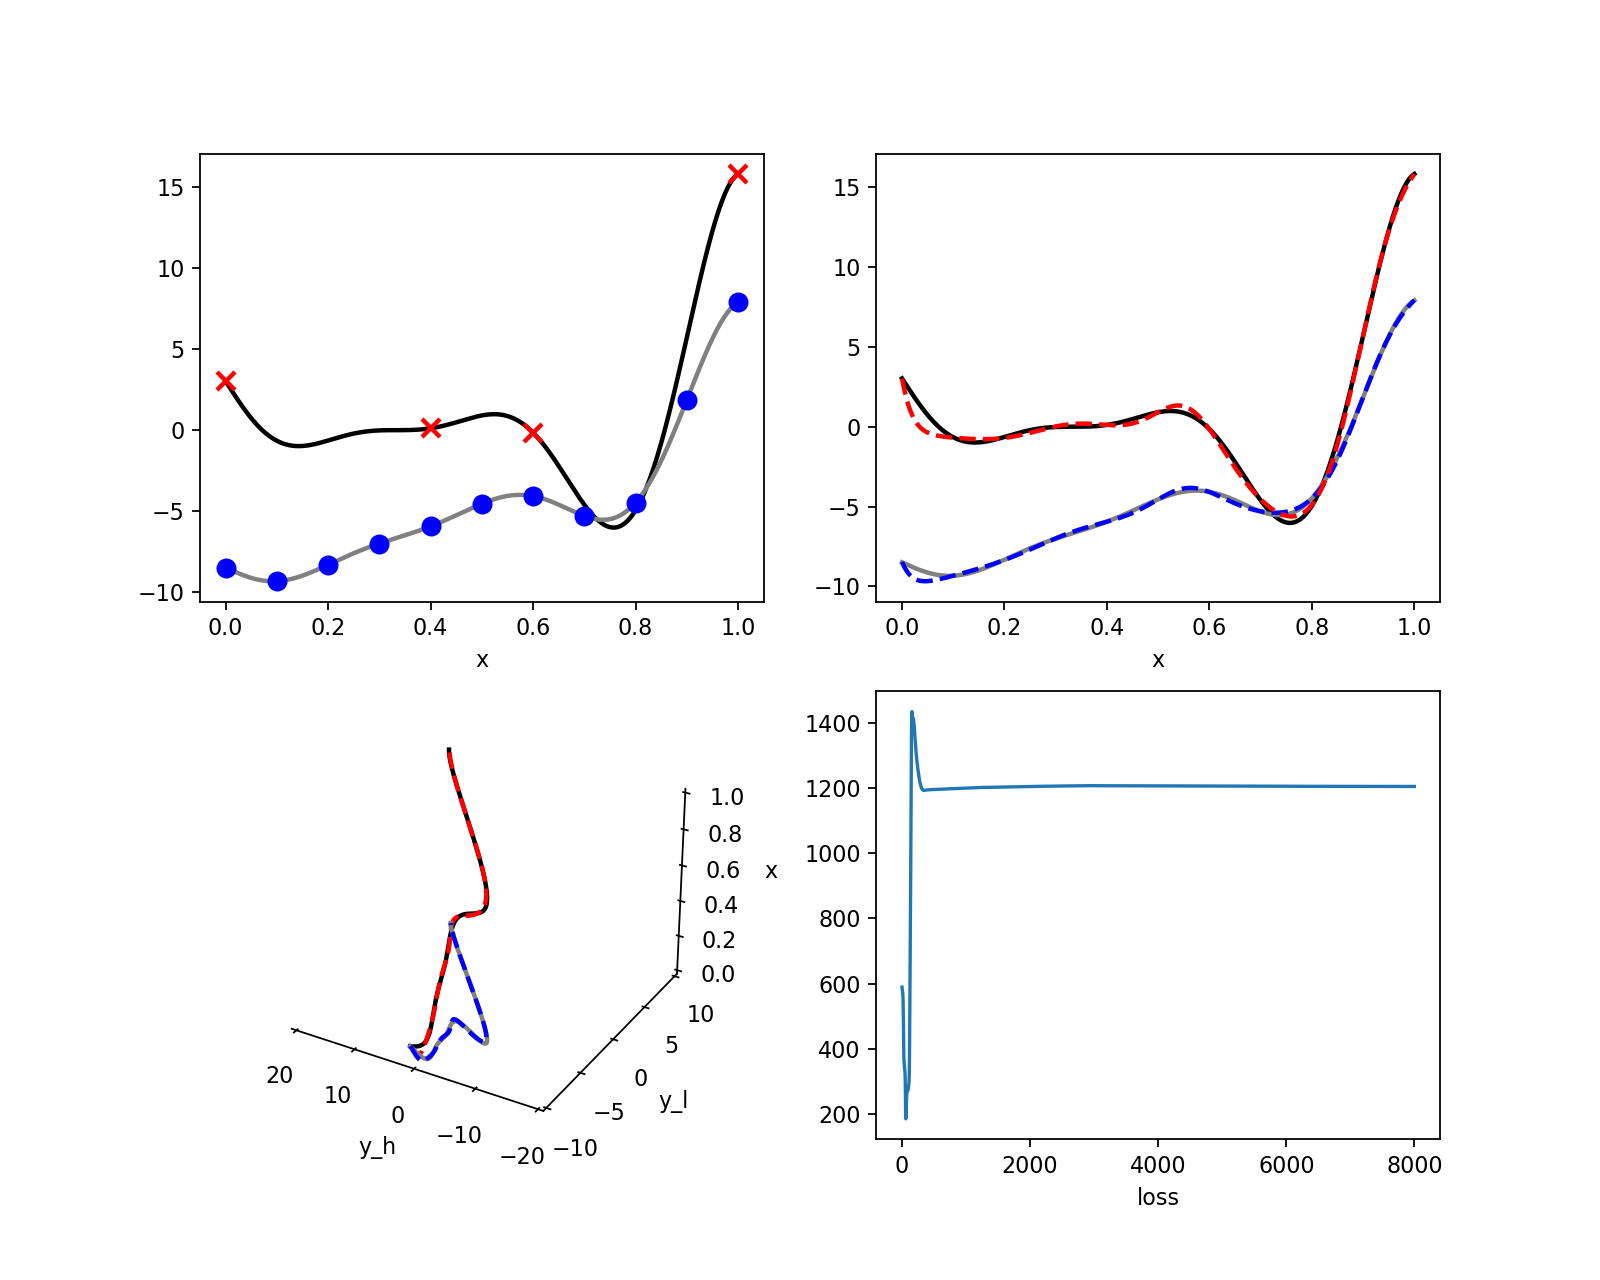

In [438]:
generate_plots(nn_mfl, train_data, num_low, high_fi, low_fi, losses, mesh_size=1000)

In [263]:
''' EXAMLE 2: Discontinuous function examle. '''
def low_fi(x): 
    small = 0.5*((6*x-2)**2)*torch.sin(12*x-4) + 10*(x-0.5)-5
    big = 3 + 0.5*((6*x-2)**2)*torch.sin(12*x-4) + 10*(x-0.5)-5
    return torch.where((x >= 0) & (x <= .5), small, big)   

def high_fi(x): 
    small = 2*low_fi(x) - 20*x + 20
    big = 4 + 2*low_fi(x) - 20*x + 20
    return torch.where((x >= 0) & (x <= .5), small, big)

def grad_low_fi(x): 
    small = 216*((1/3 - x)**2)*torch.cos(12*x-4) - (12-36*x)*torch.sin(12*x-4) + 10
    big = 216*((1/3 - x)**2)*torch.cos(12*x-4) - (12-36*x)*torch.sin(12*x-4) + 10
    return torch.where((x >= 0) & (x <= .5), small, big)

# Setu training data.
(nn_mfl, train_data, num_low, num_high) = setu_training(
    low_fi, 
    high_fi, 
    [1, 20, 20, 20, 20, 1], 
    [2, 1], 
    [2, 10, 10, 1], 
    n.linsace(0, .4, 8).tolist()+n.linsace(.4, .6, 22).tolist()+n.linsace(.6, 1, 8).tolist(), 
    [0.2, 0.4, 0.6, 0.75, 0.9]
)

# Define training arameters and run training loo.
num_eochs = 2000
lr = .001
l2_lambda_h2 = .02
l2_lambda_l = .0018
losses = train_MFNN(
    nn_mfl, 
    num_eochs, 
    lr, 
    l2_lambda_h2,
    train_data,
    num_low, 
    num_high,
    l2_lambda_l=l2_lambda_l,
    grad_low_fi=grad_low_fi,
    =2,
)

100%|██████████| 2000/2000 [12:18<00:00,  2.71it/s]


<IPython.core.display.Javascript object>


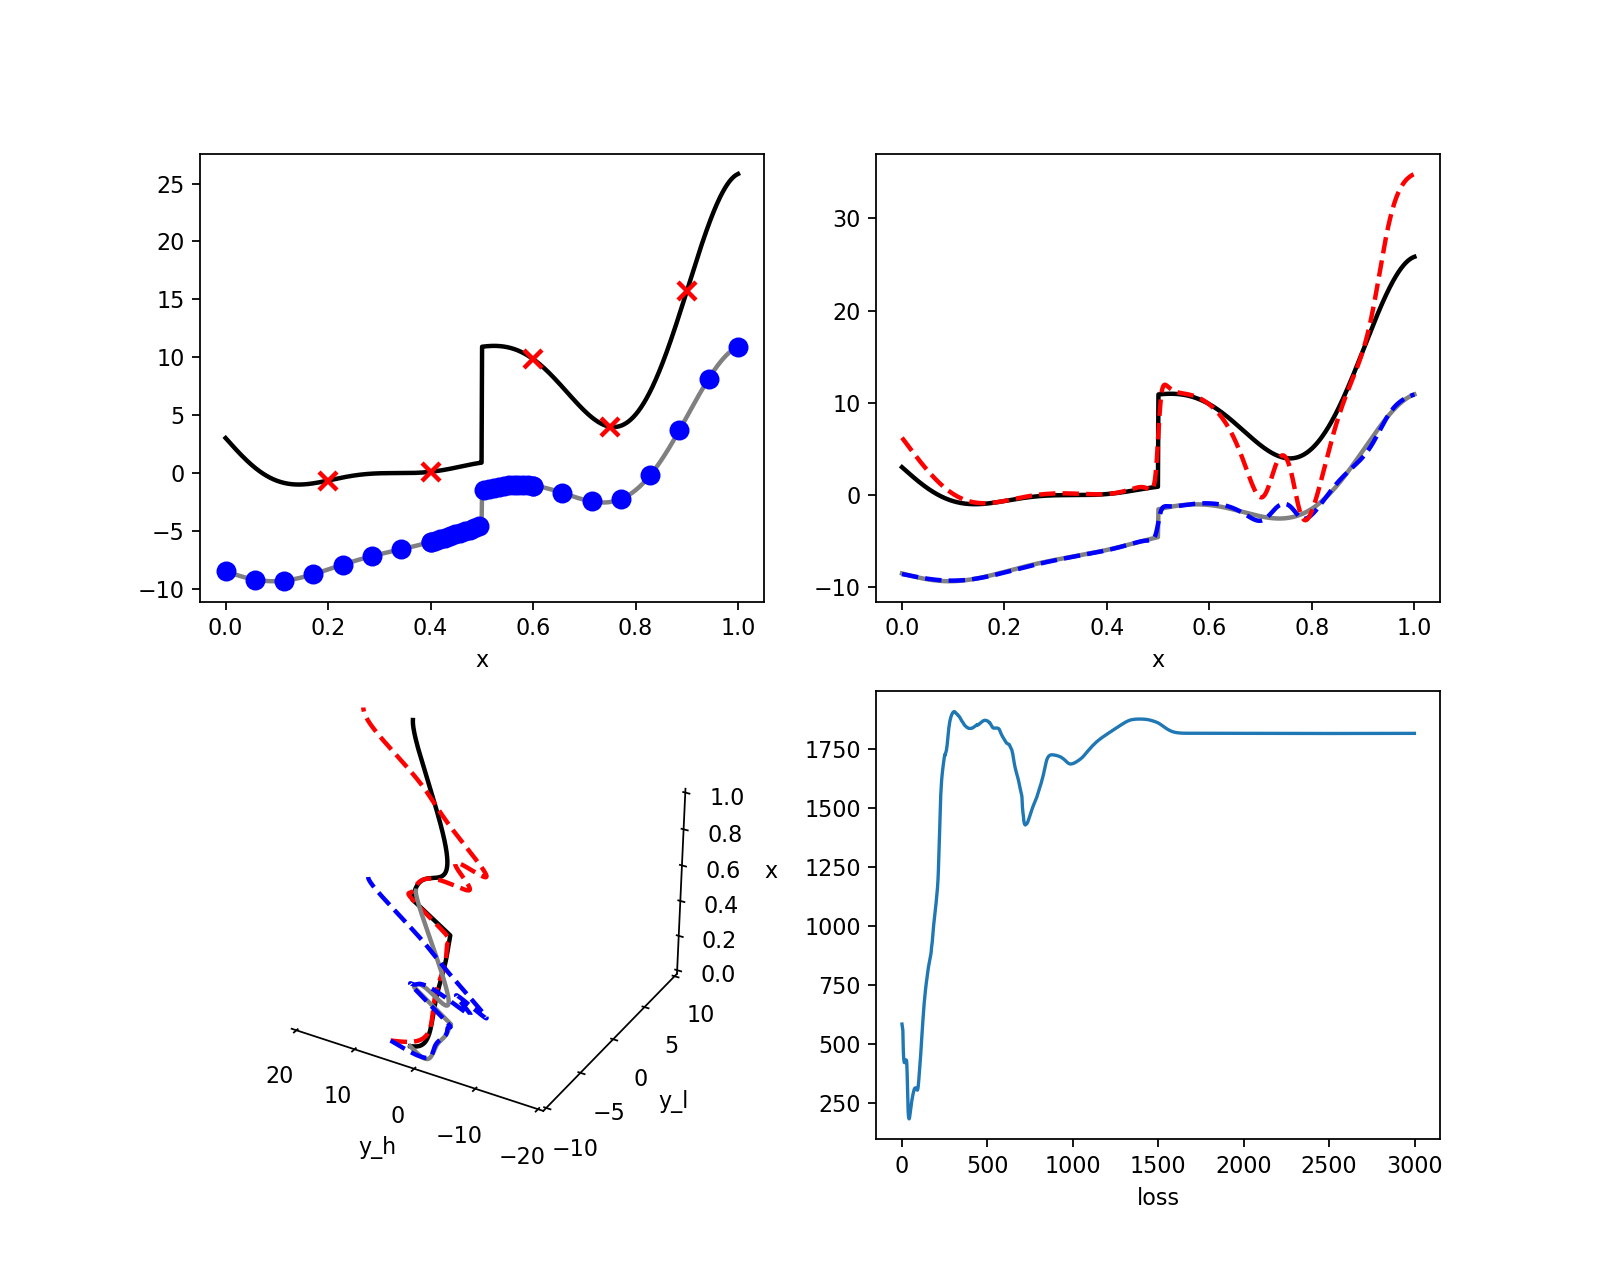

In [239]:
generate_plots(nn_mfl, train_data, num_low, high_fi, low_fi, losses, mesh_size=1000)

In [216]:
''' EXAMPLE 3: Continuous function with nonlinear correlation example. '''
def low_fi(x): 
    return torch.sin(8*math.pi*x)

def high_fi(x): 
    return (x-math.sqrt(2))*low_fi(x)*low_fi(x)

def grad_low_fi(x): 
    return torch.cos(8*math.pi*x)*8*math.pi

# Setup training data.
(nn_mfl, train_data, num_low, num_high) = setup_training(
    low_fi, 
    high_fi, 
    [1, 20, 20, 20, 20, 1], 
    [2, 1], 
    [2, 10, 10, 1], 
    np.linspace(0, 1, 51).tolist(), 
    np.arange(0, 1, step=.075).tolist(),
)

# Define training parameters and run training loop.
num_epochs = 1000
lr = .001
l2_lambda_h2 = .00029
l2_lambda_l = 0.0001
losses = train_MFNN(
    nn_mfl, 
    num_epochs, 
    lr, 
    l2_lambda_h2,
    train_data,
    num_low, 
    num_high,
    l2_lambda_l=l2_lambda_l,
    grad_low_fi=grad_low_fi,
)

100%|██████████| 1000/1000 [06:46<00:00,  2.46it/s]


<IPython.core.display.Javascript object>


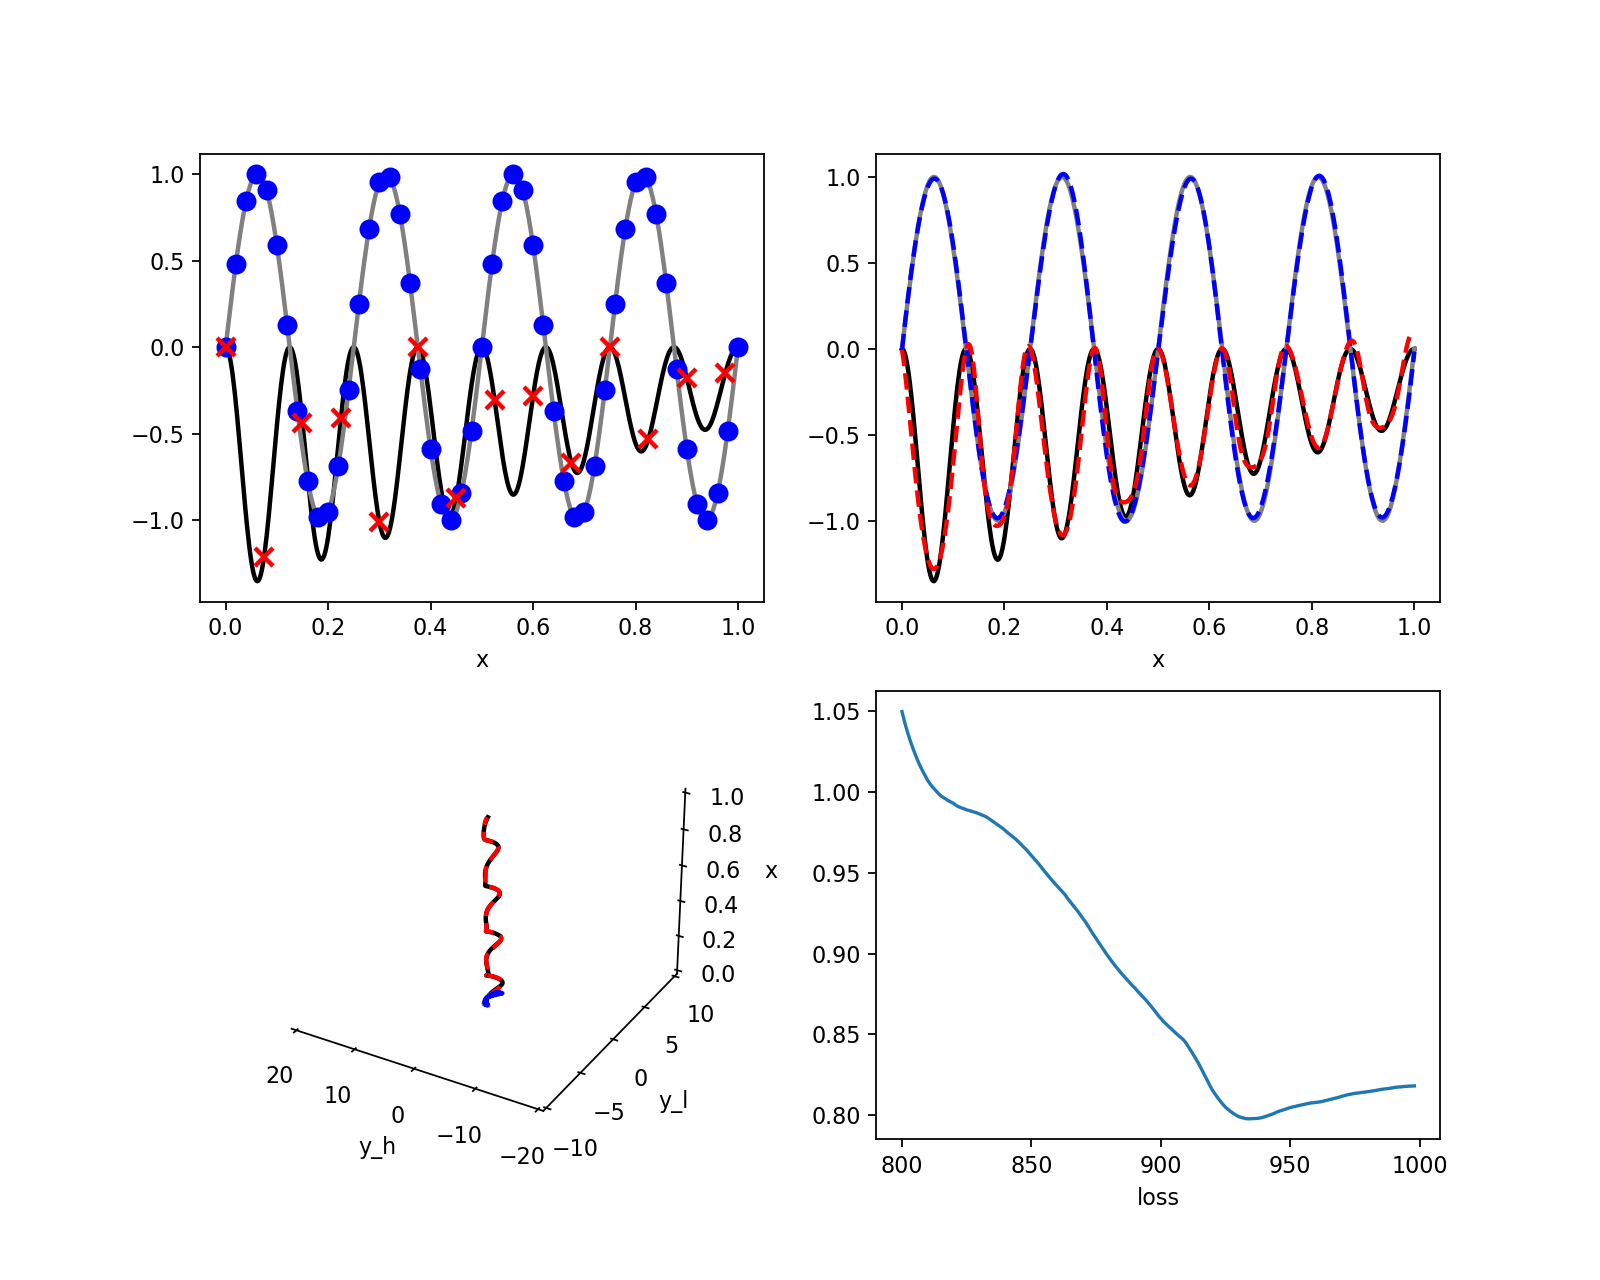

In [217]:
generate_plots(nn_mfl, train_data, num_low, high_fi, low_fi, losses, mesh_size=500, range_loss_plot=800)

In [271]:
''' EXAMPLE 4: Continuous function with phase shift and highly nonlinear correlation example. '''
def low_fi(x): 
    return torch.sin(8*math.pi*x)

def high_fi(x): 
    return x**2+(torch.sin(8*math.pi*x + math.pi/10))**2

def grad_low_fi(x): 
    return torch.sin(8*math.pi*x)

# Setup training data.
(nn_mfl, train_data, num_low, num_high) = setup_training(
    low_fi, 
    high_fi, 
    [1, 20, 20, 20, 20, 1], 
    [2, 1], 
    [3, 10, 10, 1], 
    np.linspace(0, 1, 51).tolist(), 
    np.linspace(0, 1, 16).tolist(),
    use_yl2=True, 
    tau=.0449,
)

# Define training parameters and run training loop.
num_epochs = 1000
lr = .001
l2_lambda_h2 = .004
l2_lambda_l = 0.0001
losses = train_MFNN(
    nn_mfl, 
    num_epochs, 
    lr, 
    l2_lambda_h2,
    train_data,
    num_low, 
    num_high,
    l2_lambda_l=l2_lambda_l,
    grad_low_fi=grad_low_fi,
)

100%|██████████| 1000/1000 [05:28<00:00,  3.05it/s]


<IPython.core.display.Javascript object>


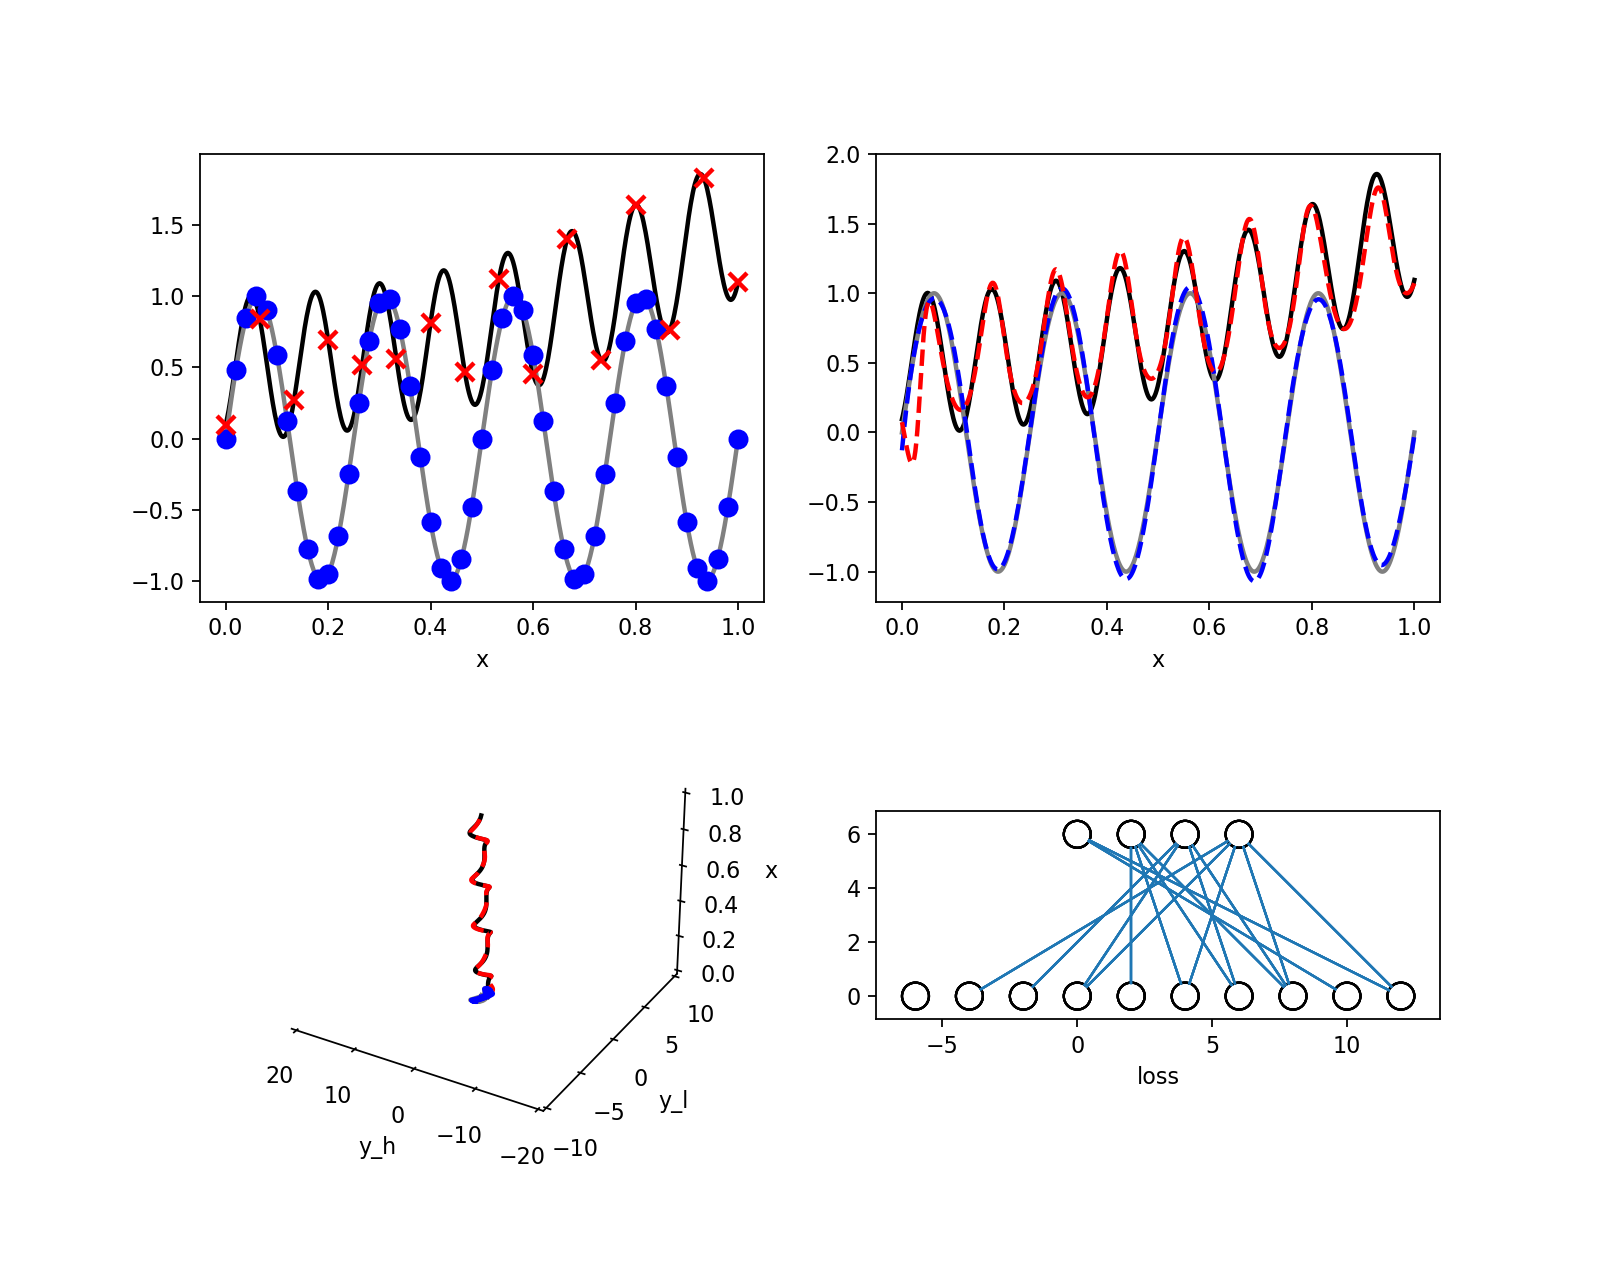

In [270]:
generate_plots(nn_mfl, train_data, num_low, high_fi, low_fi, losses, mesh_size=500, range_loss_plot=1000)

<IPython.core.display.Javascript object>


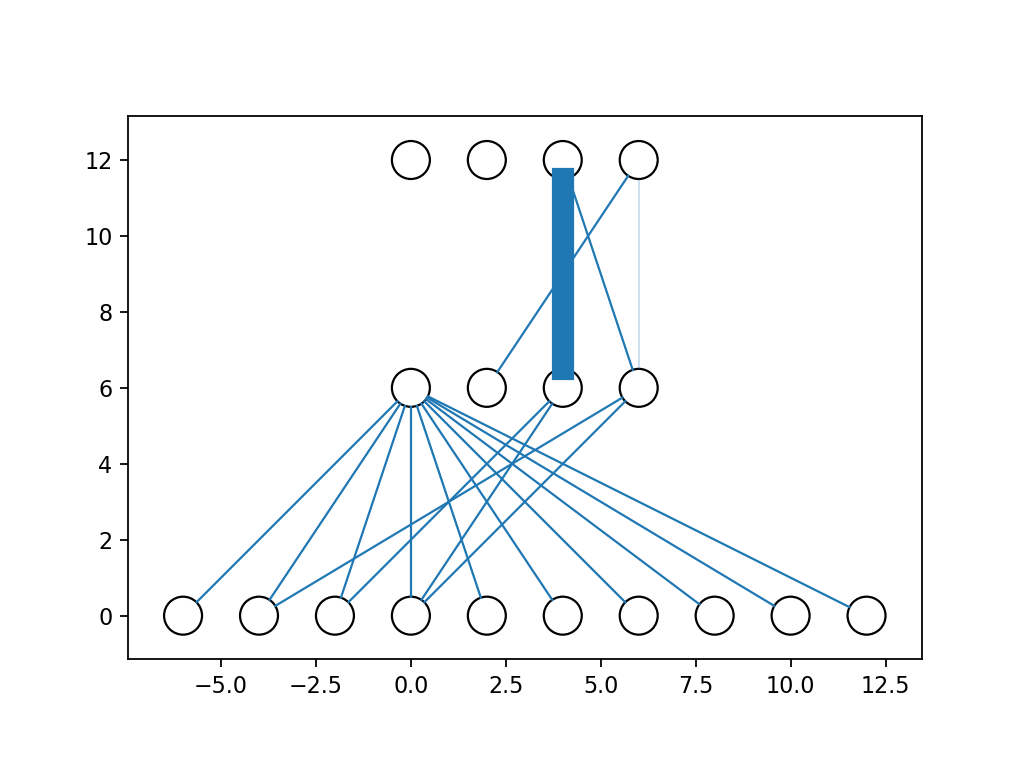

In [347]:
%matplotlib notebook

class Neuron():
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def draw(self):
        circle = plt.Circle((self.x, self.y), radius=neuron_radius, fill=False)
        plt.gca().add_patch(circle)


class Layer():
    def __init__(self, network, number_of_neurons, weights):
        self.previous_layer = self.__get_previous_layer(network)
        self.y = self.__calculate_layer_y_position()
        self.neurons = self.__intialise_neurons(number_of_neurons)
        self.weights = weights

    def __intialise_neurons(self, number_of_neurons):
        neurons = []
        x = self.__calculate_left_margin_so_layer_is_centered(number_of_neurons)
        for iteration in range(number_of_neurons):
            neuron = Neuron(x, self.y)
            neurons.append(neuron)
            x += horizontal_distance_between_neurons
        return neurons

    def __calculate_left_margin_so_layer_is_centered(self, number_of_neurons):
        return horizontal_distance_between_neurons * (number_of_neurons_in_widest_layer - number_of_neurons) / 2

    def __calculate_layer_y_position(self):
        if self.previous_layer:
            return self.previous_layer.y + vertical_distance_between_layers
        else:
            return 0

    def __get_previous_layer(self, network):
        if len(network.layers) > 0:
            return network.layers[-1]
        else:
            return None

    def __line_between_two_neurons(self, neuron1, neuron2, linewidth):
        angle = atan((neuron2.x - neuron1.x) / float(neuron2.y - neuron1.y))
        x_adjustment = neuron_radius * sin(angle)
        y_adjustment = neuron_radius * cos(angle)
        line_x_data = (neuron1.x - x_adjustment, neuron2.x + x_adjustment)
        line_y_data = (neuron1.y - y_adjustment, neuron2.y + y_adjustment)
        line = plt.Line2D(line_x_data, line_y_data, linewidth=linewidth)
        plt.gca().add_line(line)

    def draw(self):
        for this_layer_neuron_index in range(len(self.neurons)):
            neuron = self.neurons[this_layer_neuron_index]
            neuron.draw()
            if self.previous_layer:
                for previous_layer_neuron_index in range(len(self.previous_layer.neurons)):
                    previous_layer_neuron = self.previous_layer.neurons[previous_layer_neuron_index]
                    weight = self.previous_layer.weights[this_layer_neuron_index, previous_layer_neuron_index]
                    self.__line_between_two_neurons(neuron, previous_layer_neuron, weight)


class NeuralNetwork():
    def __init__(self):
        self.layers = []

    def add_layer(self, number_of_neurons, weights=None):
        layer = Layer(self, number_of_neurons, weights)
        self.layers.append(layer)

    def draw(self):
        for layer in self.layers:
            layer.draw()
        plt.axis('scaled')
        plt.show()



vertical_distance_between_layers = 6
horizontal_distance_between_neurons = 2
neuron_radius = 0.5
number_of_neurons_in_widest_layer = 4
network = NeuralNetwork()
# weights to convert from 10 outputs to 4 (decimal digits to their binary representation)
weights1 = np.array([\
                     [1,1,1,1, 1,1,1,1, 1, 1],\
                     [0,0,0,0, 0,0,0,0, 0, 0],\
                     [0,0,1,1, 0,0,0,0, 0, 0],\
                     [0,1,0,1, 0,0,0,0, 0, 0]
                    ]
                   )
weights2 = np.array([\
                     [0,0,0,0],\
                     [0,0,0,0],\
                     [0,0,10,1],\
                     [0,1,0,.2]
                    ]
                   )
network.add_layer(10, weights1)
network.add_layer(4, weights2)
network.add_layer(4)
network.draw()

In [319]:
for name, param in nn_mfl.named_parameters(): 
    if "weight" in name: 
        print(name)
        print(param.shape)

nn_l.linear_layers.0.weight
torch.Size([20, 1])
nn_l.linear_layers.1.weight
torch.Size([20, 20])
nn_l.linear_layers.2.weight
torch.Size([20, 20])
nn_l.linear_layers.3.weight
torch.Size([20, 20])
nn_l.linear_layers.4.weight
torch.Size([1, 20])
nn_h1.linear_layers.0.weight
torch.Size([1, 2])
nn_h2.linear_layers.0.weight
torch.Size([10, 3])
nn_h2.linear_layers.1.weight
torch.Size([10, 10])
nn_h2.linear_layers.2.weight
torch.Size([1, 10])


In [668]:
network = NeuralNetwork()
nn_mfl.dim_in = 1
nn_mfl.dim_out = 1
nn_h2_weight0 = None
nn_h1_weight0 = None
is_first_layer = True
# Add all layers in nn_l
for name, param in nn_mfl.named_parameters(): 
    # nn_l should show up first. 
    if "weight" in name and "nn_l" in name:
        network.add_layer(param.shape[1], param.data.numpy(), is_first_layer=is_first_layer)
        is_first_layer=False
    # Construct the first layers of nn_h1 and nn_h2.
    elif "0.weight" in name: 
        if "weight" in name and "nn_h1" in name: 
            # nn_h1 should show up first. 
            nn_h1_weight0 = param.data.numpy()
            # Copy layers which map from input layer 
            nn_h1_first_layer_weights = nn_h1_weight0[:, 0:nn_mfl.dim_in]
            left = nn_h1_weight0.shape[1] - nn_mfl.dim_in
            # Zero out input layer weights so they don't draw to the previous layer
            nn_h1_weight0[:, 0:left+1] = nn_h1_weight0[:, nn_mfl.dim_in:]
            nn_h1_weight0[:, left:] = 0
        elif "weight" in name and "nn_h2" in name: 
            # nn_h2 should show up second. 
            nn_h2_weight0 = param.data.numpy()
            nn_h2_first_layer_weights = nn_h2_weight0[:, 0:nn_mfl.dim_in]
            nn_h2_weight0[:, 0:nn_mfl.dim_in] = 0 
            # Add output node of nn_l.
            network.add_layer(nn_mfl.dim_out, np.ones((2, nn_mfl.dim_out)))
            first_layer_weights = np.concatenate(
                (nn_h1_first_layer_weights, nn_h2_first_layer_weights), 
                axis=0
            )
            weights0 = np.concatenate((nn_h1_weight0, nn_h2_weight0), axis=0)
            network.add_layer(2, weights0)
    # Only nn_h2 should have the next hidden layers. 
    elif "1.weight" in name: 
        nn_h2_weight1 = param.data.numpy()
        # Add one node to this layer for the output of nn_h1.
        network.add_layer(
            param.shape[1]+1, 
            np.concatenate((np.zeros((param.shape[0], 1)), param.data.numpy()), axis=1), 
            first_layer_weights=first_layer_weights, 
            is_first_hf_layer=True,
        )
    elif "weight" in name: 
        network.add_layer(param.shape[1], param.data.numpy())
# Add output layer
network.add_layer(nn_mfl.dim_out, first_hf_layer_weights=first_hf_layer_weights,)

<IPython.core.display.Javascript object>


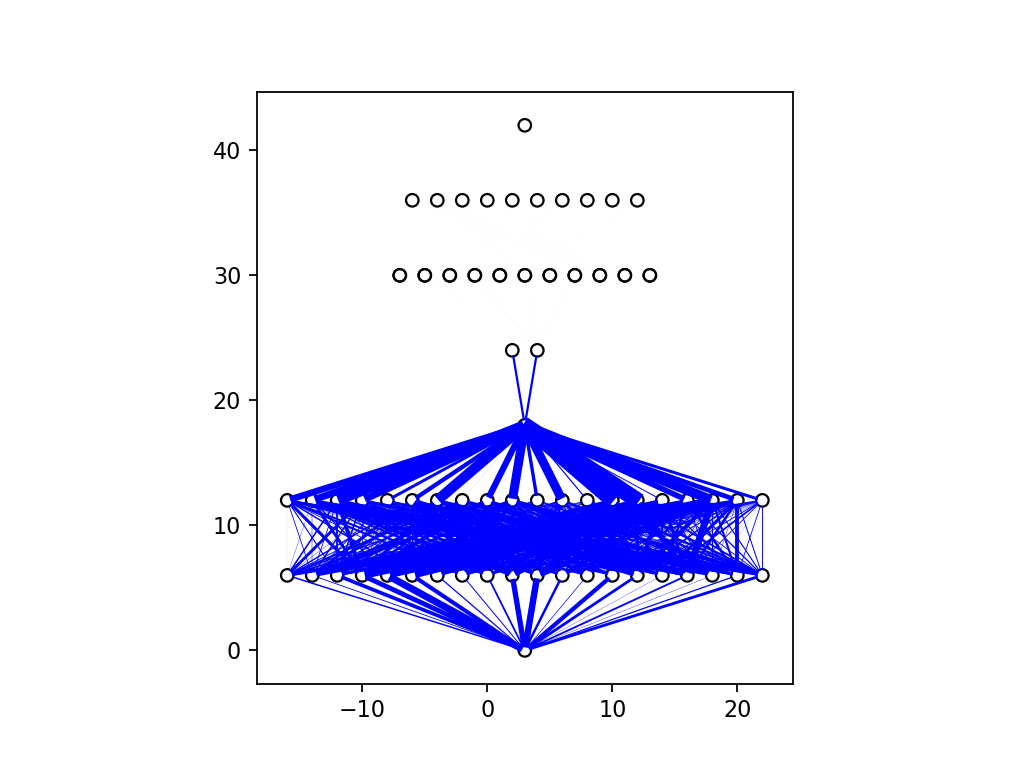

In [669]:
%matplotlib notebook
network.draw() 

In [363]:
np.array([[1], np.array([1])])

array([[1],
       [1]])

In [371]:
a = np.array([[1], [1]])

In [373]:
a.shape[1]

1

In [417]:
weights0[7][1] = 1

In [460]:
nn_h1_weight0[:, :] = 0

In [468]:
nn_h1_weight0[:, 0]

array([0.], dtype=float32)

In [489]:
np.ones((nn_mfl.dim_out, 2))

array([[1., 1.]])

In [502]:
nn_mfl2 = nn_mfl

In [509]:
a = [1]

In [637]:
nn_h2_weight1

array([[ 6.91712194e-04, -7.03246915e-04,  3.72711133e-04,
         3.68771493e-04,  3.81203572e-04,  5.98858132e-05,
         3.85827210e-04, -1.04189632e-04,  2.48599594e-04,
        -6.78175653e-04],
       [-7.47590966e-04,  7.44302524e-04, -2.92425742e-04,
        -2.91886186e-04, -3.01588268e-04,  1.91650979e-04,
        -2.98468542e-04,  2.27695564e-04, -2.64296890e-04,
         6.17663172e-05],
       [ 8.29203753e-04, -6.23938569e-04,  3.28754220e-04,
         2.95137113e-04,  2.17516645e-04, -2.14685235e-04,
         2.88564770e-04, -2.33307394e-04,  2.64658651e-04,
         2.47805165e-05],
       [-6.92430593e-04,  8.62953195e-04, -2.81107117e-04,
        -3.13291064e-04, -3.70107446e-04,  8.87433453e-06,
        -3.14016390e-04,  1.29333304e-04, -2.23340874e-04,
         5.18054701e-04],
       [-8.69437703e-04,  6.03264605e-04, -3.11317213e-04,
        -2.87105504e-04, -2.09783568e-04,  2.23763680e-04,
        -2.82348803e-04,  2.41663758e-04, -2.66357936e-04,
        -1.

In [641]:
np.ones((10, 1)).shape

(10, 1)

In [18]:
aba = {}
aba[1] = 2

In [19]:
if aba: 
    print("Hi")

Hi


In [77]:
[["blue"]*3]*3

[['blue', 'blue', 'blue'], ['blue', 'blue', 'blue'], ['blue', 'blue', 'blue']]